Версии:

- pandas==1.4.2
- numpy==1.20.3
- matplotlib==3.4.3
- seaborn==0.11.2
- lightgbm==3.3.2
- scikit-learn==1.0.2
- catboost==0.26.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter('ignore')

# EDA

## Загрузка данных

In [2]:
df = pd.read_csv(r'.\junior\classification\data_classification_for_task.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Датасет небольшой. Все данные имеют численный тип данных.

Проверим на пропуски

In [4]:
df.isnull().sum()

AGE           0
GENDER        0
FEATURE_1     0
FEATURE_2     0
FEATURE_3     0
FEATURE_4     0
FEATURE_5     0
FEATURE_6     0
FEATURE_7     0
FEATURE_8     0
FEATURE_9     0
FEATURE_10    0
FEATURE_11    0
TARGET        0
dtype: int64

Пропусков нет. Проверим на дубликаты

In [5]:
df.duplicated().sum()

1

Есть один дубликат. Избавимся от него

In [6]:
df = df.drop_duplicates().reset_index(drop=True)  # на всякий случай, так удобнее ориентироваться

Просмотр данных

In [7]:
df.sample(10)

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
283,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0
259,66,0,0,178,228,1,1,165,1,1.0,1,2,3,0
135,49,0,0,130,269,0,1,163,0,0.0,2,0,2,1
212,61,0,0,145,307,0,0,146,1,1.0,1,0,3,0
152,64,1,3,170,227,0,0,155,0,0.6,1,0,3,1
195,46,1,2,150,231,0,1,147,0,3.6,1,0,2,0
19,69,0,3,140,239,0,1,151,0,1.8,2,2,2,1
190,58,1,0,128,216,0,0,131,1,2.2,1,3,3,0
207,49,1,2,120,188,0,1,139,0,2.0,1,3,3,0
169,56,1,2,130,256,1,0,142,1,0.6,1,1,1,0


Рассмотрим характеристики столбцов

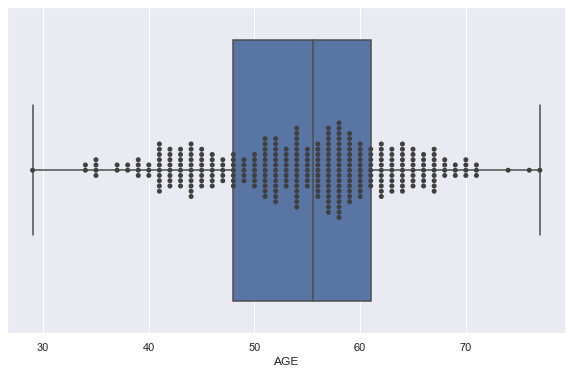

In [8]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(ax=ax, data=df, x='AGE')
sns.swarmplot(ax=ax, data=df, x='AGE', color='.25');

Как мы видим, столбец с возрастом распределен нормально, практически не смещен (среднее близко к медиане), не имеет выбросов (диапазон от 29 до 77 лет)

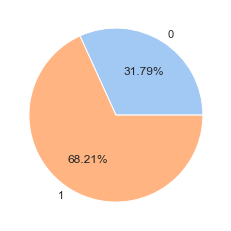

In [9]:
colors = sns.color_palette('pastel')[0:2]
gen_gb = df.groupby('GENDER')['AGE'].count()
plt.pie(gen_gb,
        labels=gen_gb.index,
        colors=colors,
        autopct='%.2f%%')
plt.title='Распределение пациентов по полу';

Пациентов с полом 1 несколько больше

Рассмотрим один из важнейших для обучения параметров - распределение по классам

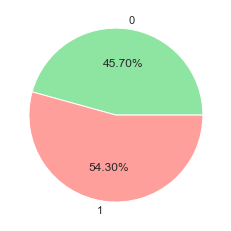

In [10]:
colors = sns.color_palette('pastel')[2:4]
tar_gb = df.groupby('TARGET')['AGE'].count()
plt.pie(tar_gb,
        labels=tar_gb.index,
        colors=colors,
        autopct='%.2f%%')
plt.title='Распределение целевого признака';

Данные сбалансированы (хотя в задании указан перекос, но он небольшой). Можно чуть поднять вес для 0 класса, но в целом это зависит от цели исследования. Нашей ключевой метрикой является F1, частный случай F-меры, когда точность и полнота имеют равный вес в формуле метрики, однако если предположить, к примеру, чрезвычайно опасную для общества болезнь, которую никак нельзя пропустить, то можно было бы оптимизировать полноту (или метрику F-Beta c б<b>о</b>льшим β). Или наоборот, какая-нибудь очень стигматизированная болячка, которую мы хотим ставить как можно меньшему числу людей, оценивалась бы через precision, либо F-Beta с β < 0

Поскольку все столбцы числовые, для просмотра статистик данных также хорошо подойдет метод `describe()`

In [11]:
df.describe(percentiles=[.01, .25, .5, .75, .99])

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,35.00000,0.000000,0.000000,100.000000,149.000000,0.000000,0.000000,95.010000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
99%,71.00000,1.000000,3.000000,180.000000,406.870000,1.000000,1.990000,191.980000,1.000000,4.200000,2.000000,3.990000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Теперь выведем общий график для признаков. Те из них, что мы еще не рассматривали, изучать отдельно не будем, поскольку природа их нам неизвестна. Из таблицы `describe()` мы видим, что признаки:

- имеют разный масштаб (так, f6 имеет максимум 564, а f4 лишь 1)
- имеют значения, большие или равные нулю
- при этом часть из них имеет значительную долю нулевых значений (1-й квантиль тоже равен нулю, а у f4 даже 3-й квантиль)

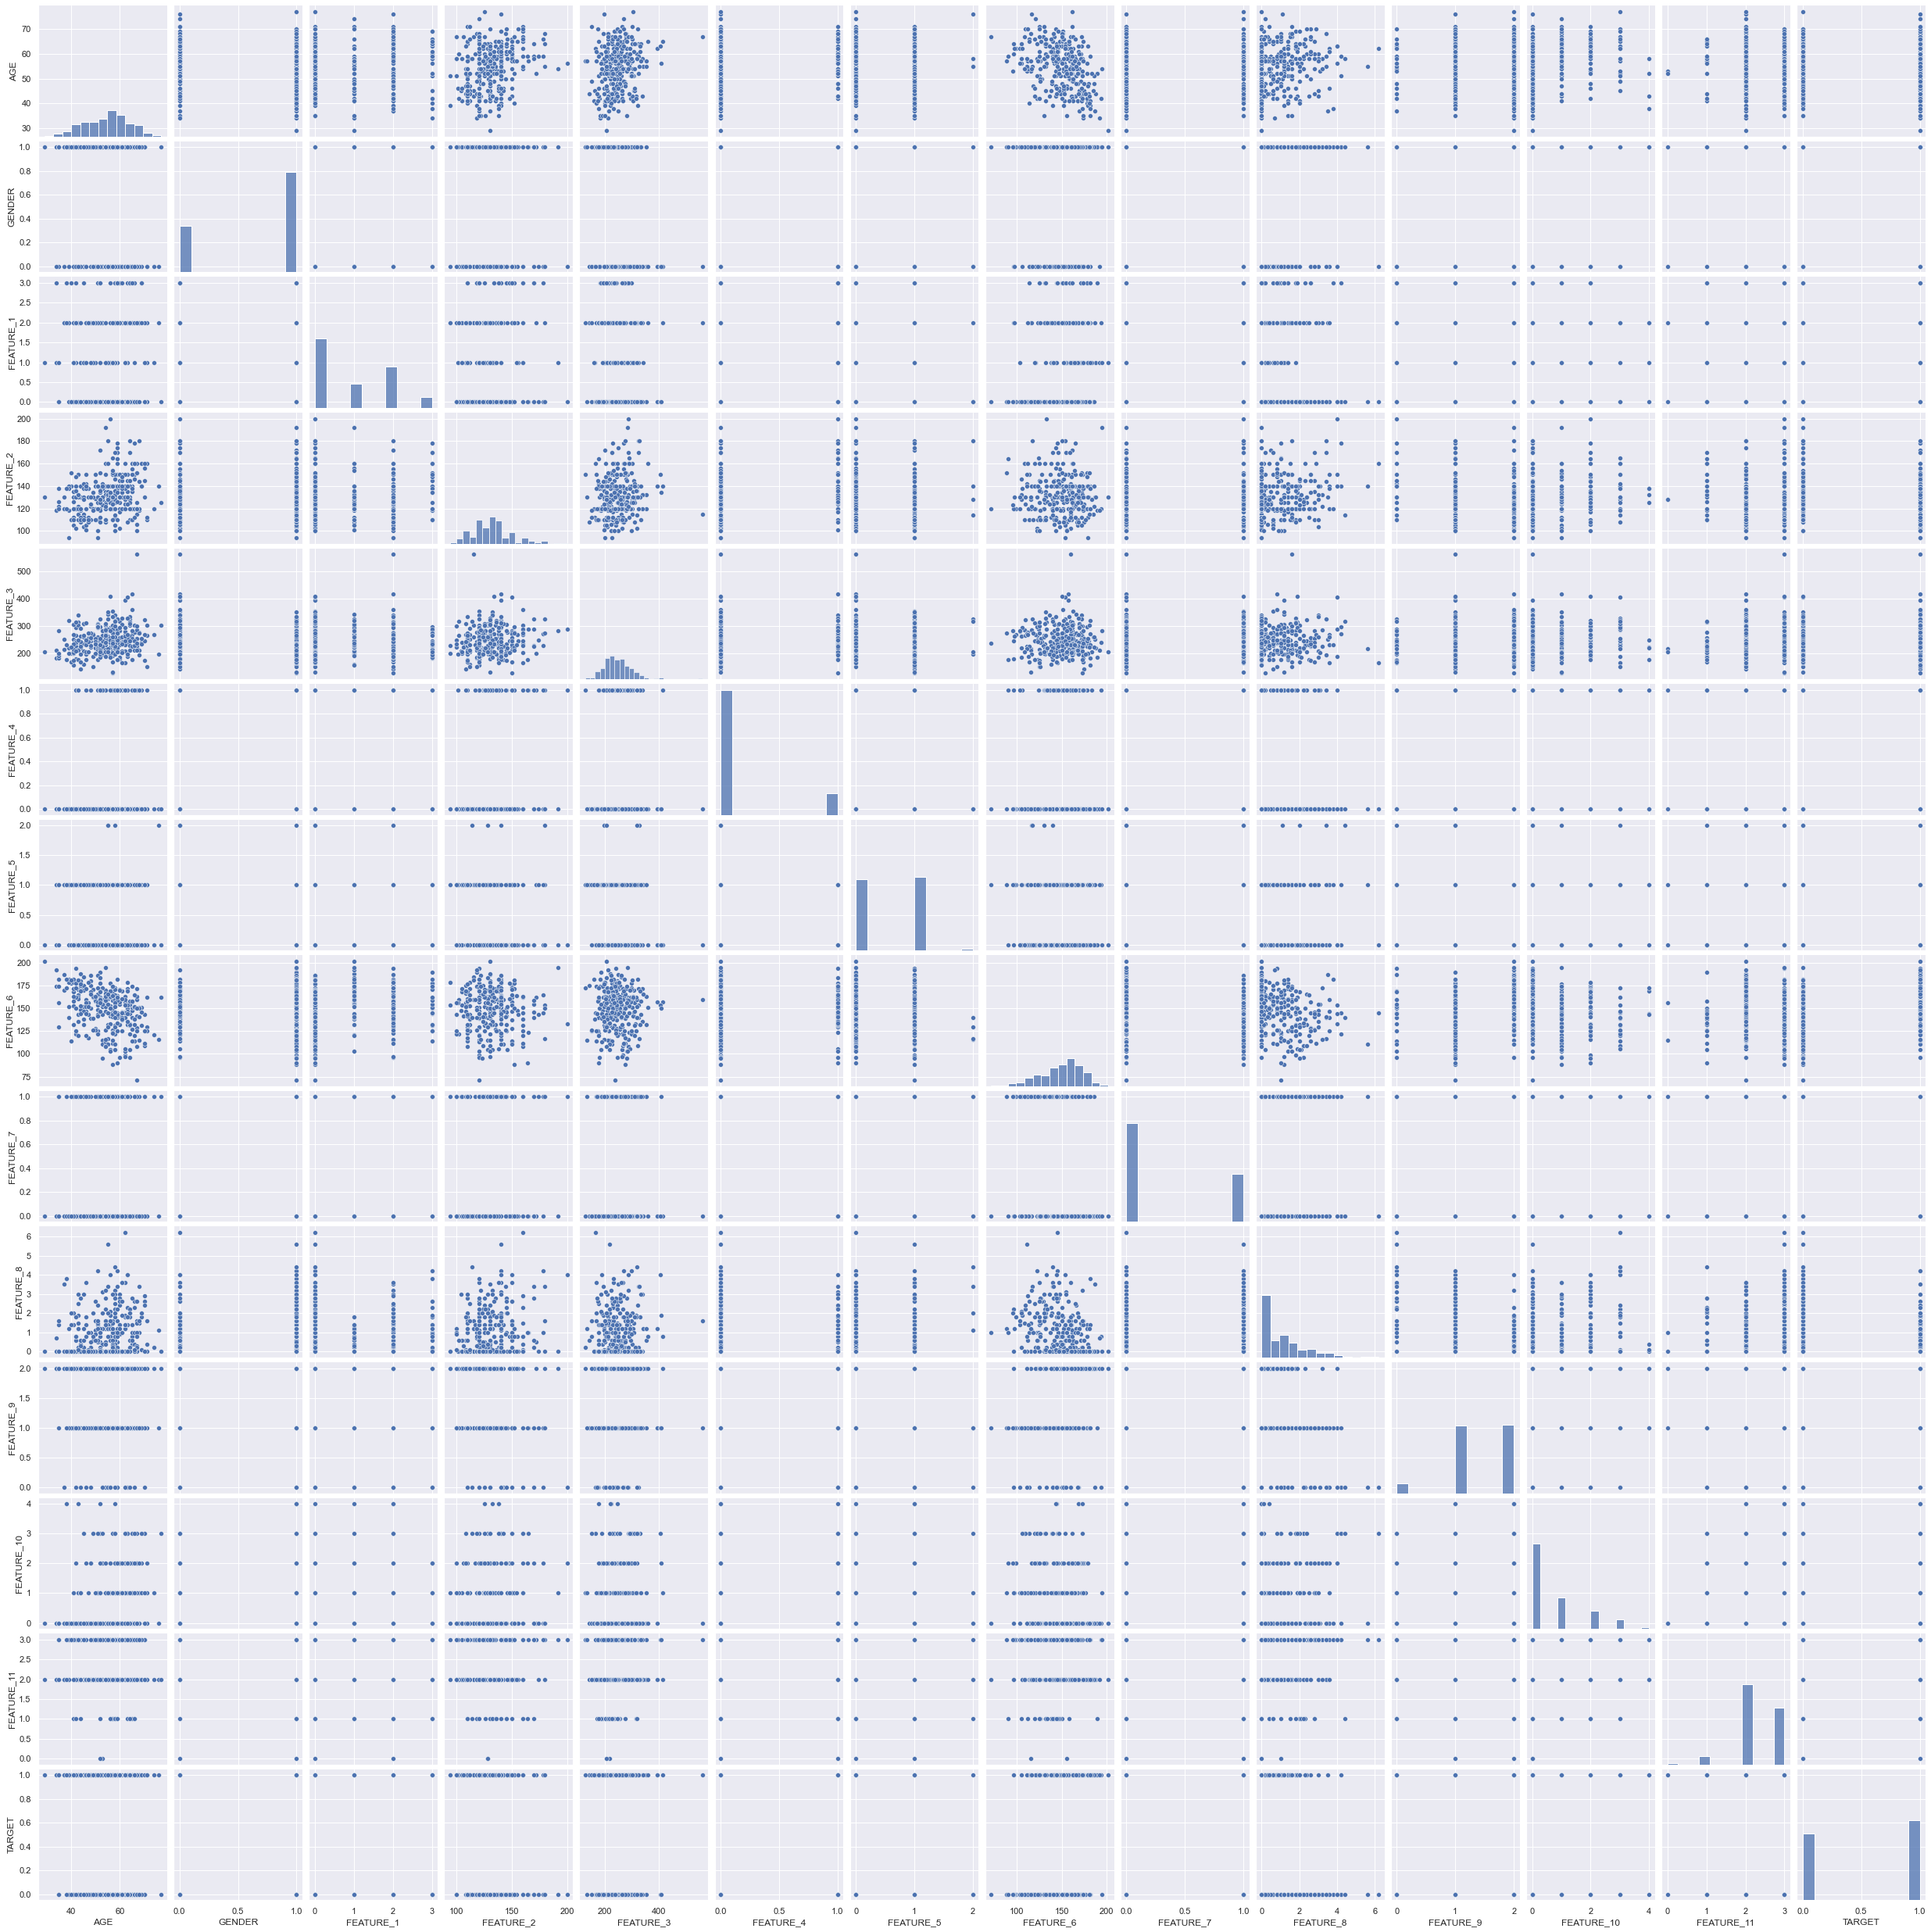

In [12]:
sns.pairplot(data=df);

Мы видим, что некоторые признаки скорее дискретные, т.к. принимают ограниченный набор значений. Посмотрим подробнее:

In [13]:
for col in df:
    print(col, '\t', len(df[col].unique()))

AGE 	 41
GENDER 	 2
FEATURE_1 	 4
FEATURE_2 	 49
FEATURE_3 	 152
FEATURE_4 	 2
FEATURE_5 	 3
FEATURE_6 	 91
FEATURE_7 	 2
FEATURE_8 	 40
FEATURE_9 	 3
FEATURE_10 	 5
FEATURE_11 	 4
TARGET 	 2


In [14]:
bin_features = ['GENDER', 'FEATURE_4', 'FEATURE_7']
cat_features = ['FEATURE_1', 'FEATURE_5', 'FEATURE_9', 'FEATURE_10', 'FEATURE_11']
num_features = ['AGE', 'FEATURE_2', 'FEATURE_3', 'FEATURE_6', 'FEATURE_8']

Посмотрим, какие значения принимают эти колонки

In [15]:
for col in bin_features + cat_features:
    print(col, '\t', df[col].unique())

GENDER 	 [1 0]
FEATURE_4 	 [1 0]
FEATURE_7 	 [0 1]
FEATURE_1 	 [3 2 1 0]
FEATURE_5 	 [0 1 2]
FEATURE_9 	 [0 2 1]
FEATURE_10 	 [0 2 1 3 4]
FEATURE_11 	 [1 2 3 0]


Можно выделить 3 бинарных признака, 3 категориальных, а остальные отнести к численным

Выведем также матрицу корреляций

<AxesSubplot:>

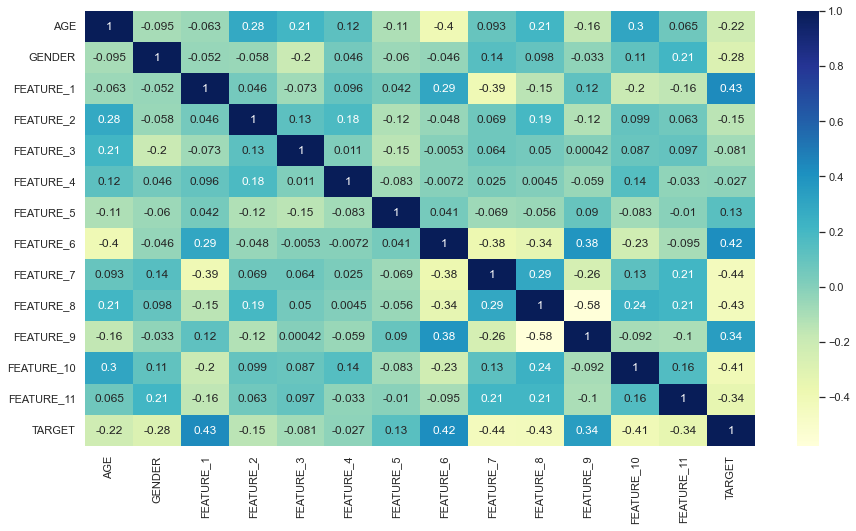

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.corr(), ax=ax, cmap='YlGnBu', annot=True)

Некоторые фичи слабо или средне коррелируют между собой. Это может оказать негативное влияние на линейные модели. При необходимости приведем отбор признаков, однако на данном этапе можно оставить как есть

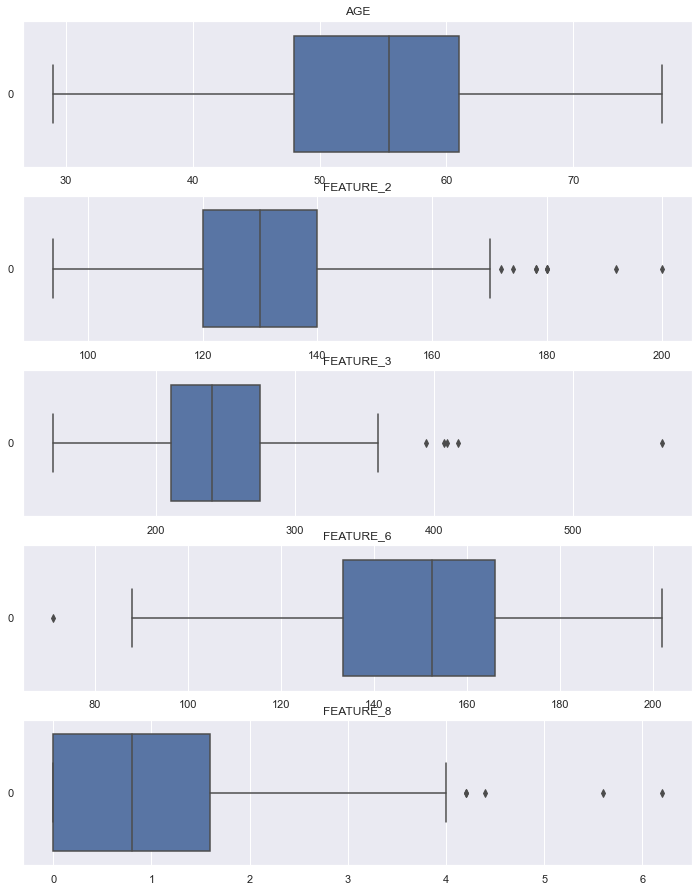

In [17]:
fig, axes = plt.subplots(len(num_features), 1, figsize=(12, 7))
for i, feature in enumerate(num_features):
    sns.boxplot(data=df[feature], orient='h', ax=axes[i])
    axes[i].set_title(feature)
plt.subplots_adjust(top=1.8, wspace=0.25)

Мы видим, что AGE (как отмечалось ранее) и f6 не имеют выбросов. Остальные признаки имеют немногочисленные выбросы, которые мы уберем на этапе пожготовки данных

## Выводы по EDA
Данные весьма неплохого качества. Классы в целевой переменной вполне сбалансированы. Фичи можно разделить на 3 категории: бинарные (включая один достоверно известный бинарный признак - возраст), потенциально категориальные - принимающие малый в сравнении с размером выборки диапазон целочисленных значений, и числовые - включая один достоверно известный дискретный признак - возраст.

Фичи имеют разные масштаб, и перед обучением будет необходимо произвести их стандартизацию. Природа части из них неизвестна, поэтому можно испытать как масшабирование этих признаков (MinMaxScaler), так и категориальное кодирование (OneHotEncoder)

# ML

## Разделение выборок

Разделим выборку на обучающую и тестовую. Поскольку данных мало, будем использовать только кросс-вадидацию

In [18]:
train, test = train_test_split(df, test_size=0.1, random_state=42)

Уберем выбросы из обучающей части

In [19]:
qf2, qf3, qf8 = train[['FEATURE_2', 'FEATURE_3', 'FEATURE_8']].quantile(.975)

Оценим кол-во строк к удалению

In [20]:
len(train.query("FEATURE_2 > @qf2 or FEATURE_3 > @qf3 or FEATURE_8 > @qf8"))

19

Не слишком много, поэтому удаляем

In [21]:
train = train.query("FEATURE_2 <= @qf2 and FEATURE_3 <= @qf3 and FEATURE_8 <= @qf8")

In [22]:
X_train, y_train = train.drop('TARGET', axis=1), train['TARGET']
X_test, y_test = test.drop('TARGET', axis=1), test['TARGET']
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Проверка размеров выборок

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(252, 13)
(252,)
(31, 13)
(31,)


## Подготовка данных

Нам неизвестна природа большинства признаков в нашей выборки, поэтому будем судить о них опытным путем. Мы выяснили, что часть из признаков принимают только два значения - 0 и 1. Их трогать не будем, вероятно, это бинарные признаки. Другие признаки принимают лишь ограниченный набор значений. Это могут быть как категориальные признаки, так и числовые дискретные. Попробуем отмасштабировать их, используя `MinMaxScaler`, также можно попробовать `OneHotEncoder` для случая, когда эти признаки означают категории. Оставшиеся - числовые - признаки, отмасштабируем, используя `StandardScaler`

In [24]:
mm_scaler = MinMaxScaler()
X_train.loc[:, cat_features] = mm_scaler.fit_transform(X_train.loc[:, cat_features])
X_test.loc[:, cat_features] = mm_scaler.transform(X_test.loc[:, cat_features])

*Experimental*  - trying OHE

In [25]:
# ohe_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# ohe_train = ohe_enc.fit_transform(X_train[cat_features])
# ohe_test = ohe_enc.transform(X_test[cat_features])
# X_train = X_train.drop(cat_features, axis=1)
# X_test = X_test.drop(cat_features, axis=1)
# X_train = pd.concat([X_train, pd.DataFrame(ohe_train)], axis=1)
# X_test = pd.concat([X_test, pd.DataFrame(ohe_test)], axis=1)

In [26]:
st_scaler = StandardScaler()
X_train.loc[:, num_features] = mm_scaler.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = mm_scaler.transform(X_test.loc[:, num_features])

## Обучение

### Sanity check (dummy classifier)

In [27]:
dummy = DummyClassifier(random_state=42)
dummy_cv = cross_val_score(dummy, X_train, y_train, scoring='f1', cv=3)
np.round(dummy_cv.mean(), 4)

0.7176

Результат: __0.7176__

### Ridge classifier

In [28]:
ridge = RidgeClassifierCV([0.1, 0.5, 0.8, 1, 1.2, 2],
                          scoring='f1', cv=3,
                          class_weight={0: 0.52, 1: 0.5},)
ridge.fit(X_train, y_train)
np.round(ridge.best_score_, 4)

0.8564

Результат: __0.8564__ (MinMaxScaler на предположительно кат. фичах); __0.8631__ при испо-и OHE

### SVM classifier

In [29]:
svc = SVC(C=1.07, random_state=42)
svc_cv = cross_val_score(svc, X_train, y_train, scoring='f1', cv=3)
np.round(svc_cv.mean(), 4)

0.8595

Результат: __0.8564__

### Random Forest classifier

In [44]:
forest_params= {
    'bootstrap': [True, False],
    'max_depth': [4, 6],
    'n_estimators': [10, 12, 15, 18],
    'min_samples_leaf': [6, 7, 8],
    'min_samples_split': [6, 7, 8],
}

In [45]:
forest = RandomForestClassifier(random_state=42)
cv = GridSearchCV(forest,
                  forest_params,
                  cv=3,
                  scoring='f1',
                  n_jobs=6)

In [46]:
%time cv.fit(X_train, y_train)

Wall time: 3.07 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=6,
             param_grid={'bootstrap': [True, False], 'max_depth': [4, 6],
                         'min_samples_leaf': [6, 7, 8],
                         'min_samples_split': [6, 7, 8],
                         'n_estimators': [10, 12, 15, 18]},
             scoring='f1')

In [33]:
cv.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'min_samples_leaf': 7,
 'min_samples_split': 6,
 'n_estimators': 12}

In [34]:
best_forest_params = {
    'bootstrap': True,
    'max_depth': 4,
    'min_samples_leaf': 7,
    'min_samples_split': 7,
    'n_estimators': 15
}

In [35]:
# forest = RandomForestClassifier(**best_forest_params).fit(X_train, y_train)  # refit without performing cv

In [36]:
np.round(cv.best_score_, 4)

0.8807

In [47]:
best_forest_model = cv.best_estimator_

Результат: __0.8826__ (Scaler), __0.8686__ (OHE)

### LightGBM boosting

In [ ]:
model = lgb.LGBMClassifier(random_state=42)

params= {'learning_rate': [0.08, 0.1, 0.12],
         'boosting_type': ['gbdt', 'goss'],
         'num_leaves': [8, 10, 12, 20, 25],
         'min_split_gain': [0, 0.01, 0.05],
         'reg_lambda': [0.1, 0.2],
         'max_depth': [2, 3, 5],
         'class_weight': [None, 'balanced'],
         'n_estimators': [50, 100, 200, 500]}

cv = GridSearchCV(model, params, cv=3,
                  scoring='f1',
                  n_jobs=6)

In [ ]:
%time cv.fit(X_train, y_train)

In [ ]:
cv.best_score_

In [ ]:
best_lgb_params = {
    'boosting_type': 'goss',
    'class_weight': None,
    'learning_rate': 0.12,
    'max_depth': 5,
    'min_split_gain': 0.05,
    'n_estimators': 50,
    'num_leaves': 8,
    'reg_lambda': 0.2
}

In [ ]:
cv.best_params_

Результат: __0.8711__ (Scaler), __0.8738__ (OHE)

In [ ]:
lgb_model = cv.best_estimator_

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.tight_layout()

Пока без селектора

In [ ]:
# model = lgb.LGBMClassifier(random_state=42)

# params= {'learning_rate': [0.08, 0.1, 0.12],
#          'boosting_type': ['gbdt', 'goss'],
#          'num_leaves': [8, 10, 12, 20, 25],
#          'min_split_gain': [0, 0.01, 0.05],
#          'reg_lambda': [0.1, 0.2],
#          'max_depth': [2, 3, 5],
#          'class_weight': [None, 'balanced'],
#          'n_estimators': [50, 100, 200, 500]}

# cv = GridSearchCV(model, params, cv=3,
#                   scoring='f1',
#                   n_jobs=6)
# X_train_selector = X_train.drop(['FEATURE_4', 'FEATURE_5', 'FEATURE_2'], axis=1)
# %time cv.fit(X_train_selector, y_train)
# cv.best_score_

### CatBoost classifier with categorical features

In [36]:
train, test = train_test_split(df, test_size=0.1, random_state=42)
X_train, y_train = train.drop('TARGET', axis=1), train['TARGET']
X_test, y_test = test.drop('TARGET', axis=1), test['TARGET']
st_scaler = StandardScaler()
X_train.loc[:, num_features] = mm_scaler.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = mm_scaler.transform(X_test.loc[:, num_features])

In [37]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [38]:
cat_model = CatBoostClassifier(logging_level='Silent',
                               cat_features=cat_features+bin_features,
                               boosting_type='Ordered',
                               # class_weights=class_weights,
                               random_state=42,
                               od_type='IncToDec',
                               eval_metric='F1')

In [40]:
%%time
cats_gs = cat_model.grid_search(
    {
        'learning_rate': [0.05, 0.1, 0.2], 
        'l2_leaf_reg': [5, 7, 10],
        'depth': [3, 4],
        'n_estimators': [100, 200, 300]
    },
    X_train,
    y_train,
    cv=3,
    plot=True,
    train_size=0.9
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.7692308	best: 0.7692308 (0)	total: 2.63s	remaining: 2m 19s
1:	loss: 0.8148148	best: 0.8148148 (1)	total: 5.12s	remaining: 2m 13s
2:	loss: 0.7692308	best: 0.8148148 (1)	total: 7.51s	remaining: 2m 7s
3:	loss: 0.7692308	best: 0.8148148 (1)	total: 10s	remaining: 2m 5s
4:	loss: 0.7692308	best: 0.8148148 (1)	total: 12.5s	remaining: 2m 2s
5:	loss: 0.7857143	best: 0.8148148 (1)	total: 15.1s	remaining: 2m
6:	loss: 0.7692308	best: 0.8148148 (1)	total: 18s	remaining: 2m 1s
7:	loss: 0.7857143	best: 0.8148148 (1)	total: 20.7s	remaining: 1m 59s
8:	loss: 0.8000000	best: 0.8148148 (1)	total: 23.2s	remaining: 1m 55s
9:	loss: 0.7857143	best: 0.8148148 (1)	total: 31s	remaining: 2m 16s
10:	loss: 0.8000000	best: 0.8148148 (1)	total: 39.7s	remaining: 2m 35s
11:	loss: 0.8000000	best: 0.8148148 (1)	total: 47.2s	remaining: 2m 45s
12:	loss: 0.7857143	best: 0.8148148 (1)	total: 55.9s	remaining: 2m 56s
13:	loss: 0.8000000	best: 0.8148148 (1)	total: 1m 3s	remaining: 3m
14:	loss: 0.8275862	best: 0.827586

Result: 0.889 (завышает, очень переобучается!)

### Test time

По результатам кросс-валидации лучше качество показал случайный лес sklearn

In [48]:
best_model = best_forest_model

In [69]:
t_y_pred = best_model.predict(X_test)
np.round(f1_score(y_test, t_y_pred), 4)

0.8235

Результат можно чуть повысить изменив порог

In [70]:
t_y_pred = best_model.predict_proba(X_test)
np.round(f1_score(y_test, t_y_pred[:, 1] > 0.4), 4)

0.8571

**Итоговый результат (F1): 0.8571**

Дополнительно приведем отчет классификации и график ROC-кривой

In [66]:
print(classification_report(y_test, t_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.82      0.82      0.82        17

    accuracy                           0.81        31
   macro avg       0.80      0.80      0.80        31
weighted avg       0.81      0.81      0.81        31



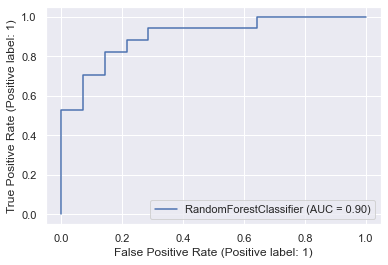

In [72]:
plot_roc_curve(best_model, X_test, y_test);

## Вывод

Полученная модель получилась сбалансированной, оба класса имеют неплохие показатели precision и recall. Результат можно улучшить, собрав больше данных, попробовав новые алгоритмы или более точно подобрав гиперпараметры к уже попробованным. Так, алгоритмы бустинга обычно имеют преимущество над случайным лесом, однако в данном случае они быстро переобучаются. Для улучшения ситуации можно провести больше экспериментов с регуляризацией, а также с помощью общих способов (сбор данных и пр.), приведенных выше. Наконец, можно попробовать сгенерировать новые признаки из уже существующих, на что, к сожадению, не хватило времени.